In [16]:
%matplotlib inline
%load_ext heat

effective entropy for eta=0.7 and r=4 is 0.0
[0. 0. 0.]
135.0
[0.7471509 +0.j 0.04283908+0.j 0.0405133 +0.j 0.03356061+0.j
 0.02259652+0.j 0.06159161+0.j 0.03375386+0.j 0.01799413+0.j]
(0.9999999999999996+0j)


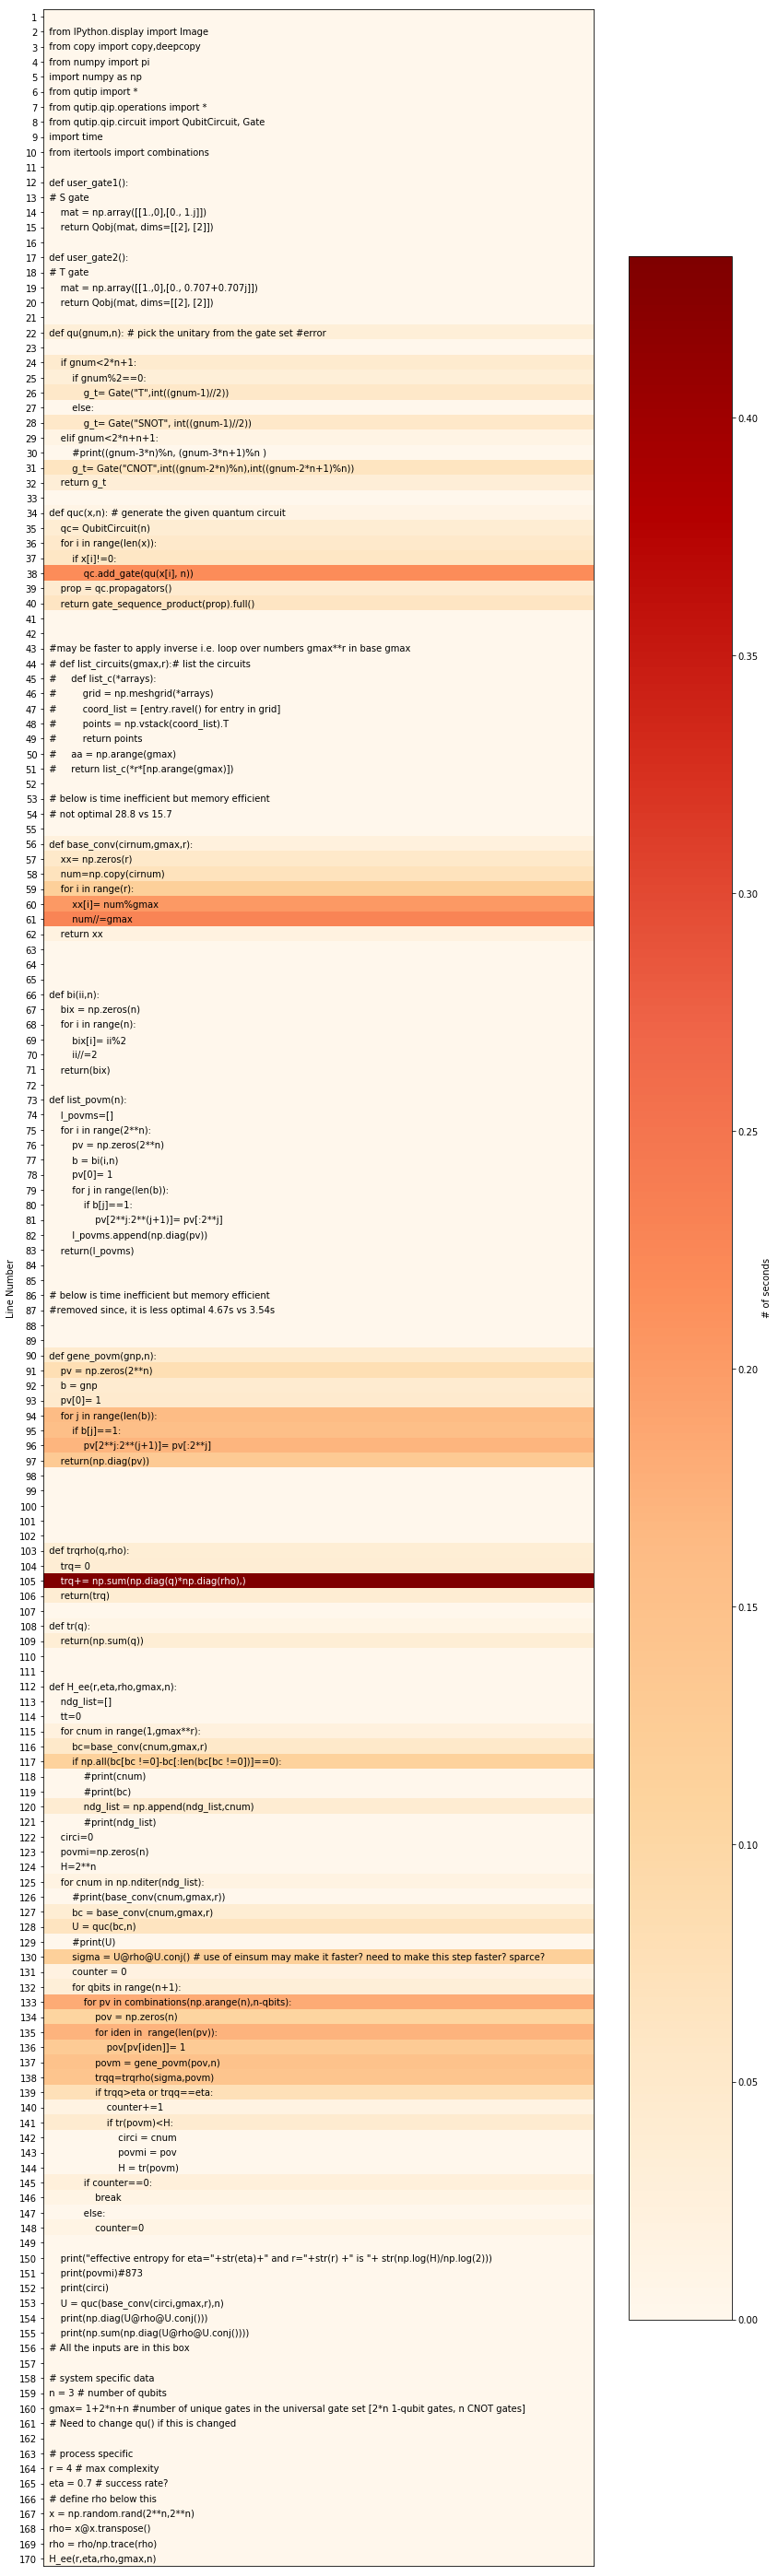

In [17]:
%%heat

from IPython.display import Image
from copy import copy,deepcopy
from numpy import pi
import numpy as np
from qutip import *
from qutip.qip.operations import *
from qutip.qip.circuit import QubitCircuit, Gate
import time
from itertools import combinations

def user_gate1():
# S gate
    mat = np.array([[1.,0],[0., 1.j]])
    return Qobj(mat, dims=[[2], [2]])

def user_gate2():
# T gate
    mat = np.array([[1.,0],[0., 0.707+0.707j]])
    return Qobj(mat, dims=[[2], [2]])

def qu(gnum,n): # pick the unitary from the gate set #error
    
    if gnum<2*n+1:
        if gnum%2==0:
            g_t= Gate("T",int((gnum-1)//2)) 
        else:
            g_t= Gate("SNOT", int((gnum-1)//2))
    elif gnum<2*n+n+1:
        #print((gnum-3*n)%n, (gnum-3*n+1)%n )
        g_t= Gate("CNOT",int((gnum-2*n)%n),int((gnum-2*n+1)%n))
    return g_t

def quc(x,n): # generate the given quantum circuit
    qc= QubitCircuit(n)
    for i in range(len(x)):
        if x[i]!=0:
            qc.add_gate(qu(x[i], n))
    prop = qc.propagators()
    return gate_sequence_product(prop).full()
    

#may be faster to apply inverse i.e. loop over numbers gmax**r in base gmax
# def list_circuits(gmax,r):# list the circuits
#     def list_c(*arrays): 
#         grid = np.meshgrid(*arrays)        
#         coord_list = [entry.ravel() for entry in grid]
#         points = np.vstack(coord_list).T
#         return points
#     aa = np.arange(gmax)
#     return list_c(*r*[np.arange(gmax)])

# below is time inefficient but memory efficient
# not optimal 28.8 vs 15.7

def base_conv(cirnum,gmax,r): 
    xx= np.zeros(r)
    num=np.copy(cirnum)
    for i in range(r): 
        xx[i]= num%gmax
        num//=gmax
    return xx



def bi(ii,n):
    bix = np.zeros(n)
    for i in range(n): 
        bix[i]= ii%2
        ii//=2
    return(bix)

def list_povm(n): 
    l_povms=[]
    for i in range(2**n):
        pv = np.zeros(2**n)
        b = bi(i,n)
        pv[0]= 1
        for j in range(len(b)): 
            if b[j]==1:
                pv[2**j:2**(j+1)]= pv[:2**j]
        l_povms.append(np.diag(pv))
    return(l_povms)


# below is time inefficient but memory efficient
#removed since, it is less optimal 4.67s vs 3.54s


def gene_povm(gnp,n): 
    pv = np.zeros(2**n)
    b = gnp
    pv[0]= 1
    for j in range(len(b)): 
        if b[j]==1:
            pv[2**j:2**(j+1)]= pv[:2**j]
    return(np.diag(pv)) 

            
                
                

def trqrho(q,rho):
    trq= 0
    trq+= np.sum(np.diag(q)*np.diag(rho),)
    return(trq)

def tr(q): 
    return(np.sum(q))


def H_ee(r,eta,rho,gmax,n):
    ndg_list=[]
    tt=0
    for cnum in range(1,gmax**r):
        bc=base_conv(cnum,gmax,r)
        if np.all(bc[bc !=0]-bc[:len(bc[bc !=0])]==0):
            #print(cnum)
            #print(bc)
            ndg_list = np.append(ndg_list,cnum)
            #print(ndg_list)
    circi=0
    povmi=np.zeros(n)
    H=2**n
    for cnum in np.nditer(ndg_list):
        #print(base_conv(cnum,gmax,r))
        bc = base_conv(cnum,gmax,r)
        U = quc(bc,n)
        #print(U)
        sigma = U@rho@U.conj() # use of einsum may make it faster? need to make this step faster? sparce?
        counter = 0
        for qbits in range(n+1): 
            for pv in combinations(np.arange(n),n-qbits):
                pov = np.zeros(n)
                for iden in  range(len(pv)):
                    pov[pv[iden]]= 1
                povm = gene_povm(pov,n)
                trqq=trqrho(sigma,povm)
                if trqq>eta or trqq==eta: 
                    counter+=1
                    if tr(povm)<H:
                        circi = cnum
                        povmi = pov
                        H = tr(povm)
            if counter==0:
                break
            else: 
                counter=0

    print("effective entropy for eta="+str(eta)+" and r="+str(r) +" is "+ str(np.log(H)/np.log(2)))
    print(povmi)#873
    print(circi)
    U = quc(base_conv(circi,gmax,r),n)
    print(np.diag(U@rho@U.conj()))
    print(np.sum(np.diag(U@rho@U.conj())))
# All the inputs are in this box 

# system specific data
n = 3 # number of qubits
gmax= 1+2*n+n #number of unique gates in the universal gate set [2*n 1-qubit gates, n CNOT gates]
# Need to change qu() if this is changed

# process specific
r = 4 # max complexity
eta = 0.7 # success rate? 
# define rho below this
x = np.random.rand(2**n,2**n)
rho= x@x.transpose()
rho = rho/np.trace(rho)
H_ee(r,eta,rho,gmax,n)



In [13]:
# All the inputs are in this box 

# system specific data
n = 3 # number of qubits
gmax= 1+2*n+n #number of unique gates in the universal gate set [2*n 1-qubit gates, n CNOT gates]
# Need to change qu() if this is changed

# process specific
r = 4 # max complexity
eta = 0.7 # success rate? 
# define rho below this
x = np.random.rand(2**n,2**n)
rho= x@x.transpose()
rho = rho/np.trace(rho)

In [14]:
%prun H_ee(r,eta,rho,gmax,n)

effective entropy for eta=0.7 and r=4 is 0.0
[0. 0. 0.]
135.0
[0.78252651+0.j 0.01246854+0.j 0.02508291+0.j 0.0290476 +0.j
 0.04832203+0.j 0.02274166+0.j 0.04294906+0.j 0.03686171+0.j]
(0.9999999999999996+0j)
 

In [7]:
k =25
bb = np.random.rand(2**k)
bc = np.random.rand(2**k)

def iint(x):
    for i in range(10**x):
        int(493256/35)
def bint(x): 
    for i in range(10**x):
        (493256//35)
    

In [8]:
%timeit iint(7)

1 loop, best of 5: 812 ms per loop


In [9]:
%timeit bint(7)

10 loops, best of 5: 117 ms per loop


In [10]:
q = QubitCircuit(1, reverse_states=False)
about()



QuTiP: Quantum Toolbox in Python
Copyright (c) QuTiP team 2011 and later.
Current admin team: Alexander Pitchford, Nathan Shammah, Shahnawaz Ahmed, Neill Lambert, Eric Giguère, Boxi Li and Jake Lishman.
Board members: Daniel Burgarth, Robert Johansson, Anton F. Kockum, Franco Nori and Will Zeng.
Original developers: R. J. Johansson & P. D. Nation.
Previous lead developers: Chris Granade & A. Grimsmo.
Currently developed through wide collaboration. See https://github.com/qutip for details.

QuTiP Version:      4.6.0
Numpy Version:      1.20.2
Scipy Version:      1.1.0
Cython Version:     0.29.22
Matplotlib Version: 3.0.2
Python Version:     3.7.3
Number of CPUs:     4
BLAS Info:          OPENBLAS
OPENMP Installed:   False
INTEL MKL Ext:      False
Platform Info:      Linux (x86_64)
Installation path:  /home/nkothako/.local/lib/python3.7/site-packages/qutip
Please cite QuTiP in your publication.
For your convenience a bibtex reference can be easily generated using `qutip.cite()`


In [ ]:
print(povmi)#873
print(circi)
U = quc(base_conv(circi,gmax,r),n)
print(np.diag(U@rho@U.conj()))
print(np.sum(np.diag(U@rho@U.conj())))